# Experiment 3: Learning to regenerate

> Conducting the third experiment which is training the automaton to regenerate its form following a corruption, such as deleting a part or creating a hole

In [ ]:
#| default_exp learning_to_regenerate

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from NeuralCellularAutomata_PyTorch.core import *
from NeuralCellularAutomata_PyTorch.learning_to_grow import *
from NeuralCellularAutomata_PyTorch.what_persists_exists import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from functools import partial
import fastcore.all as fc

In [ ]:
batch_size = 8
n_epochs = 8000

In [ ]:
path = '../images/emoji_u1f98e.png'

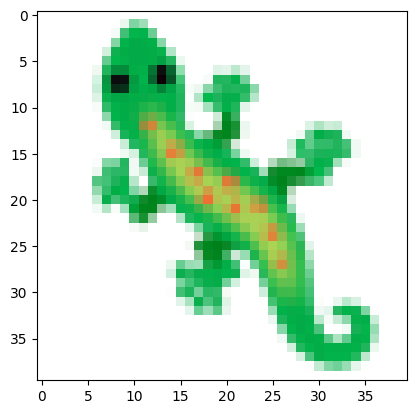

In [ ]:
img_tensor = load_image(path)

# Pool Training with holes

We want to add the ability to the pool of samples to generate corrupted samples as well, meaning samples containing random holes. 

We start by creating a function that receives a batch of images and creates a random hole in each one of them.

In [ ]:
#| export 

def create_hole(batch):
    B, C, H, W = batch.shape

    # create a grid with the same size as the batch and values in the range [-1, 1]
    grid = torch.meshgrid(torch.linspace(-1, 1, H), torch.linspace(-1, 1, W))
    grid = torch.stack(grid, dim=0).unsqueeze(0).repeat(B, 1, 1, 1)

    # create a tensor containing the locations of the centers of the holes
    center = torch.rand(B, 2, 1, 1) - 0.5        # random uniform destribution in the range [-0.5, 0.5]
    # create a tensor containing the radius of each hole
    radius = 0.3 * torch.rand(B, 1, 1, 1) + 0.1   # random uniform destribution in the range [0.1, 0.4]
    
    mask = ((grid - center) * (grid - center)).sum(1, keepdim=True).sqrt() > radius

    return batch * mask.float().to(batch.device)

In [ ]:
corrupted_image = create_hole(img_tensor)

/home/vvr/anaconda3/envs/fastai/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


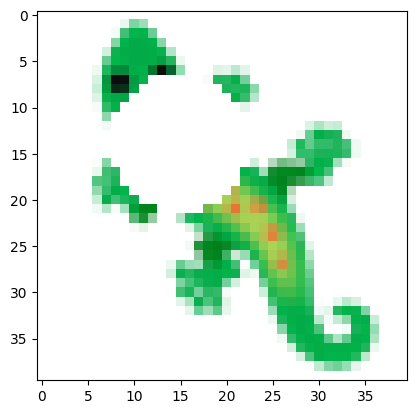

In [ ]:
plt.imshow(corrupted_image[0].detach().cpu().permute(1, 2, 0))
plt.show()

In [ ]:
#| export 

class CorruptedPool(SamplePool):


    def sample_with_damage(self, num_samples=8, damaged_samples=3):
        # selecting a random sample from the pool
        self.idxs = torch.randperm(self.pool_size)[:num_samples]
        batch = self.pool[self.idxs, ...]

        # sort the indexes according to the loss
        losses = self.loss_fn(batch[:, :4, :, :])
        sorted_idxs = torch.argsort(losses)

        # find the sample in the batch with the highest loss and replace it with the seed
        # to avoid "catastrofic forgetting" (i.e. forgetting how to generate the target from the seed)
        replace_idx = sorted_idxs[-1]
        batch[replace_idx] = self.seed[0]

        # find the k(=damaged_samples) samples with the lowest losses
        # and add some damage to them
        damaged_idxs = sorted_idxs[:damaged_samples]

        # create a hole in the selected images
        batch[damaged_idxs] = create_hole(batch[damaged_idxs])

        return batch

In [ ]:
loss_fn = partial(mse, target=img_tensor.repeat(batch_size, 1, 1, 1).to(def_device))

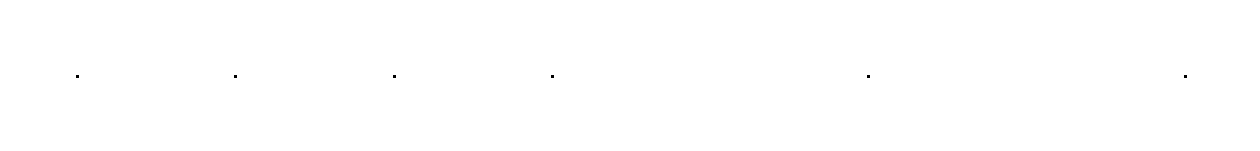

In [ ]:
pool = CorruptedPool(1024, loss_fn=loss_fn)
batch = pool.sample_with_damage()
vis_batch(batch)

# Training Loop

In [ ]:
#|eval: false


# Instantiate the model
ca = CAModel(CHANNEL_N).to(def_device)

# Optimization
lr = 2e-3
lr_gamma = 0.9999
betas = (0.5, 0.5)
optimizer = torch.optim.Adam(ca.parameters(), lr=lr, betas=betas)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, lr_gamma)

target = img_tensor.repeat(batch_size, 1, 1, 1)

In [ ]:
#|eval: false


for i in tqdm(range(n_epochs)):
    # zero the optimizer
    optimizer.zero_grad()

    # set the number of steps to take
    steps = torch.randint(64, 96, (1,)).item()

    # sample the pool to get the input
    model_in = pool.sample_with_damage()

    # activate the model
    res = ca(model_in, steps=steps)

    # calculate the loss
    loss = F.mse_loss(res[:, :4], target) # we only care about the RGBA channels

    # update the pool
    pool.update(res)

    # log the loss
    if i%500 == 0:
        print(f"Epoch: {i} Loss: {loss.item()}")

    # backpropagate the loss and update the weights
    loss.backward()
    optimizer.step()
    scheduler.step()

  0%|                                        | 1/8000 [00:00<1:29:22,  1.49it/s]

Epoch: 0 Loss: 0.11324034631252289


  6%|██▌                                     | 503/8000 [00:37<08:42, 14.35it/s]

Epoch: 500 Loss: 0.029659921303391457


 13%|████▉                                  | 1003/8000 [01:13<08:13, 14.19it/s]

Epoch: 1000 Loss: 0.01154416985809803


 19%|███████▎                               | 1503/8000 [01:49<07:29, 14.45it/s]

Epoch: 1500 Loss: 0.009176425635814667


 25%|█████████▊                             | 2003/8000 [02:25<07:06, 14.06it/s]

Epoch: 2000 Loss: 0.004854139406234026


 31%|████████████▏                          | 2503/8000 [03:00<06:32, 14.02it/s]

Epoch: 2500 Loss: 0.0035146409645676613


 38%|██████████████▋                        | 3003/8000 [03:36<05:46, 14.41it/s]

Epoch: 3000 Loss: 0.0019474619766697288


 44%|█████████████████                      | 3503/8000 [04:12<05:45, 13.01it/s]

Epoch: 3500 Loss: 0.0017854450270533562


 50%|███████████████████▌                   | 4003/8000 [04:48<04:43, 14.12it/s]

Epoch: 4000 Loss: 0.0013569763395935297


 56%|█████████████████████▉                 | 4503/8000 [05:24<04:09, 13.99it/s]

Epoch: 4500 Loss: 0.0009505663765594363


 63%|████████████████████████▍              | 5003/8000 [06:00<03:41, 13.51it/s]

Epoch: 5000 Loss: 0.0013342727907001972


 69%|██████████████████████████▊            | 5503/8000 [06:36<02:45, 15.10it/s]

Epoch: 5500 Loss: 0.001305947545915842


 75%|█████████████████████████████▎         | 6003/8000 [07:11<02:14, 14.81it/s]

Epoch: 6000 Loss: 0.00037199087091721594


 81%|███████████████████████████████▋       | 6503/8000 [07:47<01:45, 14.19it/s]

Epoch: 6500 Loss: 0.0005692397826351225


 88%|██████████████████████████████████▏    | 7003/8000 [08:23<01:15, 13.26it/s]

Epoch: 7000 Loss: 0.00025373895186930895


 94%|████████████████████████████████████▌  | 7503/8000 [08:59<00:36, 13.63it/s]

Epoch: 7500 Loss: 0.0003689015575218946


100%|███████████████████████████████████████| 8000/8000 [09:35<00:00, 13.90it/s]


In [ ]:
#|eval: false


images = ca.grow_animation(seed, 200)
display_animation(images)

The automato manages to maintain it's shape as time passes. 

### Visualize a batch from the updated pool. 

During the training process we update the samples inside the pool. 
Let's visualize how a sample would look like after the training process is completed. 

In [ ]:
#|eval: false


batch = pool.sample_with_damage()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


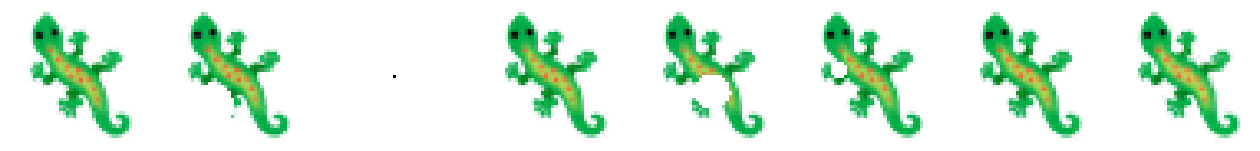

In [ ]:
#|eval: false


vis_batch(batch)

## Test the reconstruction ability of a model

In [ ]:
#|eval: false


# Generate an automato which we want to corrupt
generated = ca(seed, steps=96).detach()

### Corruption 1:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<matplotlib.image.AxesImage>

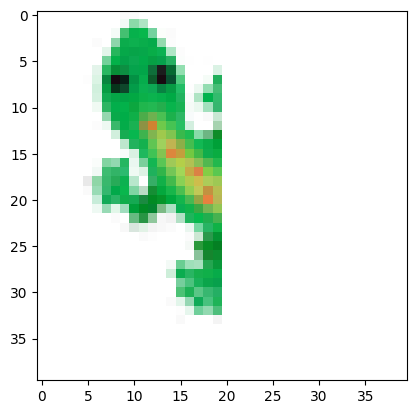

In [ ]:
#|eval: false


corrupted_input1 = generated.clone()
corrupted_input1[..., 20:] = 0

plt.imshow(corrupted_input1[0].permute(1, 2, 0)[:, :, :4].cpu())

In [ ]:
#|eval: false


images = ca.grow_animation(corrupted_input1, 300)
display_animation(images)

### Corruption 2:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<matplotlib.image.AxesImage>

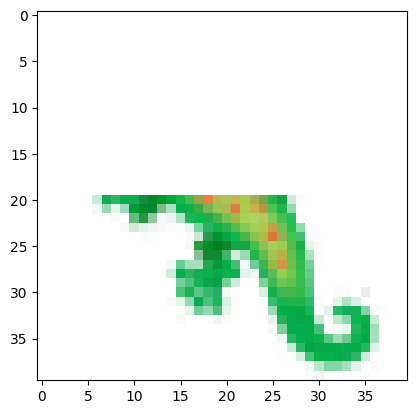

In [ ]:
#|eval: false

corrupted_input2 = generated.clone()
corrupted_input2[..., :20,:] = 0

plt.imshow(corrupted_input2[0].permute(1, 2, 0)[:, :, :4].cpu())

In [ ]:
#|eval: false

images = ca.grow_animation(corrupted_input2, 300)
display_animation(images)